In [1]:
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("../src")
from interpret import Abs_interpreter
from domain import Interval
import numpy as np

In [2]:
# Class to handle interval domain operations
class IntervalDomainHandler():
    def add(self, i1, i2):
        return (i1[0]+i2[0], i1[1]+i2[1])
    
    def subtract(self, i1, i2):
        return (i1[0]-i2[1], i1[1]-i2[0])
    
    def mul(self, i1, i2):
        op1 = i1[0] * i2[0]
        op2 = i1[0] * i2[1]
        op3 = i1[1] * i2[0]
        op4 = i1[1] * i2[1]
        
        return (min(op1, op2, op3, op4), max(op1, op2, op3, op4))

In [3]:
mu = .01 / np.pi

def compute_pinn_burgers_residual_bounds(model_name, 
                                         inpx_range = (-1 + 0.001, 1 - 0.001), 
                                         inpt_range = (0 + 0.001, 1 - 0.001), 
                                         abstract_domain = 'Interval'):
    """
    Takes in a pinn burgers model, input range and the abstract domain.
    Computes the residual bound of the model on that input range using the specified abstract domain.
    """
    model = torch.load(model_name)
    
    if abstract_domain == 'Interval':
        domain = Interval()
    else:
        raise NotImplementedError("Unknown abstract domain: " + domain)
        
    abs_interpreter = Abs_interpreter(model, domain)
    lows = torch.tensor([inpx_range[0], inpt_range[0]]).reshape(-1,1)
    highs = torch.tensor([inpx_range[1], inpt_range[1]]).reshape(-1,1)
    val_bounds, deriv_bounds, deriv2_bounds = abs_interpreter.forward_pass(lows, highs)

    ul = val_bounds[0][0][0].item()
    ur = val_bounds[1][0][0].item()
    
    uxl = deriv_bounds[0][0][0].item()
    utl = deriv_bounds[0][0][1].item()
    
    uxr = deriv_bounds[1][0][0].item()
    utr = deriv_bounds[1][0][1].item()
    
#     print(deriv2_bounds)
    uxxl = deriv2_bounds[0][0][0].item()
    uxxr = deriv2_bounds[1][0][0].item()
#     print(uxxl, uxxr)
        
    interval_handler = IntervalDomainHandler()
    
    
    # ut + u*ux - mu*uxx
    residual_bounds = interval_handler.add((utl, utr), interval_handler.mul((ul, ur), (uxl, uxr)))
    residual_bounds = interval_handler.subtract(residual_bounds, (mu*uxxl, mu*uxxr))
    return residual_bounds

## Bounds without splitting
print(compute_pinn_burgers_residual_bounds("../trained_models/pinn-burgers.pt"))
print(compute_pinn_burgers_residual_bounds("../trained_models/pinn-burgers-vis.pt"))
print(compute_pinn_burgers_residual_bounds("../trained_models/pinn-burgers_weak.pt"))

(-3099.03947305414, 2953.5979534400294)
(-554.8469060334509, 505.6887503774507)
(-63.13605765095802, 59.494583046208874)


## Computing bounds using input splitting

In [4]:
def compute_pinn_bounds_using_input_splitting(model_name, 
                                              num_partitions, 
                                              inpx_range = (-1 + 0.001, 1 - 0.001), 
                                              inpt_range = (0 + 0.001, 1 - 0.001), 
                                              abstract_domain = 'Interval'):
    """
    Compute pinn_burger bounds on the specified input range by partitioning into the specified
    number of partitions.
    """
    xeps = (inpx_range[1] - inpx_range[0])/num_partitions
    teps = (inpt_range[1] - inpt_range[0])/num_partitions

    l_final = None
    u_final = None

    for i in range(num_partitions):
        for j in range(num_partitions):
            bounds = compute_pinn_burgers_residual_bounds(model_name, 
                                                          inpx_range=(inpx_range[0] + xeps*i, inpx_range[0] + xeps*(i+1)),
                                                          inpt_range=(inpt_range[0] + teps*j, inpt_range[0] + teps*(j+1)),
                                                          abstract_domain = abstract_domain)

            if l_final is None: l_final = bounds[0]
            if u_final is None: u_final = bounds[1]

            l_final = min(l_final, bounds[0])
            u_final = max(u_final, bounds[1])

    return l_final, u_final

## Analysis of pinn_burgers and pinn-burgers_weak (trained without residual loss)

In [ ]:
# x between 0.1 to 1
model1 = "../trained_models/pinn-burgers-vis.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
x_range = (-1.0, -0.25)

# partitions = 1
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 10
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 30
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 50
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 70
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 100
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

partitions = 300
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
print("Pinn-burgers:", bounds1)

In [ ]:
# x between 0.1 to 1
model2 = "../trained_models/pinn-burgers-vis.pt"
model1 = "../trained_models/pinn-burgers_weak.pt"

# partitions = 1
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 10
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 30
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 50
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 70
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

# partitions = 100
# bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
# print("Pinn-burgers:", bounds1)

partitions = 300
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range=x_range)
print("Pinn-burgers:", bounds1)

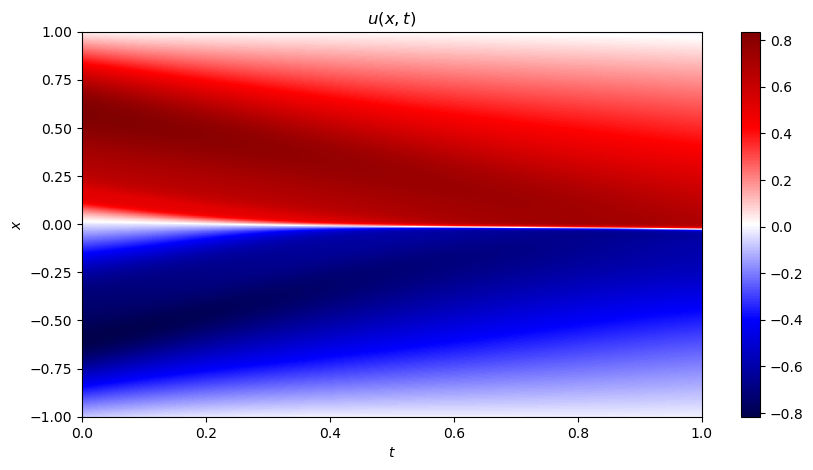

In [10]:
model2 = "../trained_models/pinn-burgers-vis.pt"
# model2 = "../trained_models/pinn-burgers_weak.pt"
model = torch.load(model2)
plt.figure(figsize = (10, 5))
n = 1000
xs, ts = torch.meshgrid(torch.linspace(-1.0, 1, n), torch.linspace(0.0, 1.0, n))
xs = xs.reshape(-1, 1).requires_grad_(False)
ts = ts.reshape(-1, 1).requires_grad_(False)
f = model(torch.cat([xs, ts], dim=1)).reshape((n ,n))
heatmap = plt.imshow(f.detach().numpy(), extent=[0,1,-1,1], cmap='seismic', interpolation='nearest', aspect='auto')
plt.colorbar(heatmap)
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title(r'$u(x,t)$')
plt.show()

In [ ]:
# x between -1 to -0.1
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 100
inpx_range = (-1, -0.1)
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range)
bounds2 = compute_pinn_bounds_using_input_splitting(model2, partitions, inpx_range)

print("Pinn-burgers:", bounds1)
print("Pinn-burgers_weak:", bounds2)

In [ ]:
# x between -0.1 to 0.1
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 100
inpx_range = (-0.1, 0.1)
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpx_range)
bounds2 = compute_pinn_bounds_using_input_splitting(model2, partitions, inpx_range)

print("Pinn-burgers:", bounds1)
print("Pinn-burgers_weak:", bounds2)

In [ ]:
# Time between 0 and 0.2
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 100
inpt_range = (0, 0.2)
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpt_range=inpt_range)
bounds2 = compute_pinn_bounds_using_input_splitting(model2, partitions, inpt_range=inpt_range)

print("Pinn-burgers:", bounds1)
print("Pinn-burgers_weak:", bounds2)

In [ ]:
# Time between 0.2 and 1
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 100
inpt_range = (0.2, 1)
bounds1 = compute_pinn_bounds_using_input_splitting(model1, partitions, inpt_range=inpt_range)
bounds2 = compute_pinn_bounds_using_input_splitting(model2, partitions, inpt_range=inpt_range)

print("Pinn-burgers:", bounds1)
print("Pinn-burgers_weak:", bounds2)

## Visualizing per partition bounds

In [ ]:
def visualize_per_partition_bounds(model_name, 
                                 num_partitions, 
                                 inpx_range = (-1 + 0.001, 1 - 0.001), 
                                 inpt_range = (0 + 0.001, 1 - 0.001), 
                                 abstract_domain = 'Interval'):
    xeps = (inpx_range[1] - inpx_range[0])/num_partitions
    teps = (inpt_range[1] - inpt_range[0])/num_partitions

    l_final = None
    u_final = None
    
    t = []
    for i in range(num_partitions):
        for j in range(num_partitions):
            inpx = (inpx_range[0] + xeps*i, inpx_range[0] + xeps*(i+1))
            inpt = (inpt_range[0] + teps*j, inpt_range[0] + teps*(j+1))
            bounds = compute_pinn_burgers_residual_bounds(model_name, 
                                                          inpx_range=inpx,
                                                          inpt_range=inpt,
                                                          abstract_domain = abstract_domain)
            
            t.append(max(abs(bounds[0]), abs(bounds[1])))
    
    t = torch.tensor(t).reshape(num_partitions, num_partitions)
    heatmap = plt.imshow(t.detach().numpy(), 
                         extent=[inpt_range[0], inpt_range[1], inpx_range[0], inpx_range[1]], 
                         cmap='Blues', interpolation='nearest', aspect='auto')
    plt.colorbar(heatmap)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
    plt.title(r'$u_t + u * u_x$')
    plt.show()

In [ ]:
model0 = "../trained_models/pinn-burgers.pt"
model1 = "../trained_models/pinn-burgers-vis.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 100
inpx_range = (0.25,0.3)
inpt_range = (0.8, 1)
# visualize_per_partition_bounds(model0, partitions, inpx_range = inpx_range, inpt_range = inpt_range)
visualize_per_partition_bounds(model1, partitions, inpx_range = inpx_range, inpt_range = inpt_range)
visualize_per_partition_bounds(model2, partitions, inpx_range = inpx_range, inpt_range = inpt_range)

In [ ]:
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 200
inpt_range = (0, 0.2)
visualize_per_partition_bounds(model1, partitions, inpt_range=inpt_range)
visualize_per_partition_bounds(model2, partitions, inpt_range=inpt_range)

In [ ]:
model1 = "../trained_models/pinn-burgers.pt"
model2 = "../trained_models/pinn-burgers_weak.pt"
partitions = 200
inpt_range = (0.2, 1)
visualize_per_partition_bounds(model1, partitions, inpt_range=inpt_range)
visualize_per_partition_bounds(model2, partitions, inpt_range=inpt_range)